In [ ]:
# Dataset taken from
# https://www.kaggle.com/mlg-ulb/creditcardfraud


In [66]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score
from sklearn.metrics import classification_report, auc, roc_curve, f1_score 
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from pylab import rcParams
rcParams['figure.figsize'] = 14,8
RANDOM_SEED = 42
LABELS =['Normal', 'Fraud']



In [38]:
df = pd.read_csv('creditcard.csv', sep=',')

In [39]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [40]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]
print(f'No. of Total Cases are {df.shape[0]}')
print(f'Percentage of fraud cases are {100*fraud.shape[0] /(fraud.shape[0]+normal.shape[0])}')

No. of Total Cases are 284807
Percentage of fraud cases are 0.1727485630620034


In [41]:
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


Text(0.5, 1.0, 'Frequency of observation number')

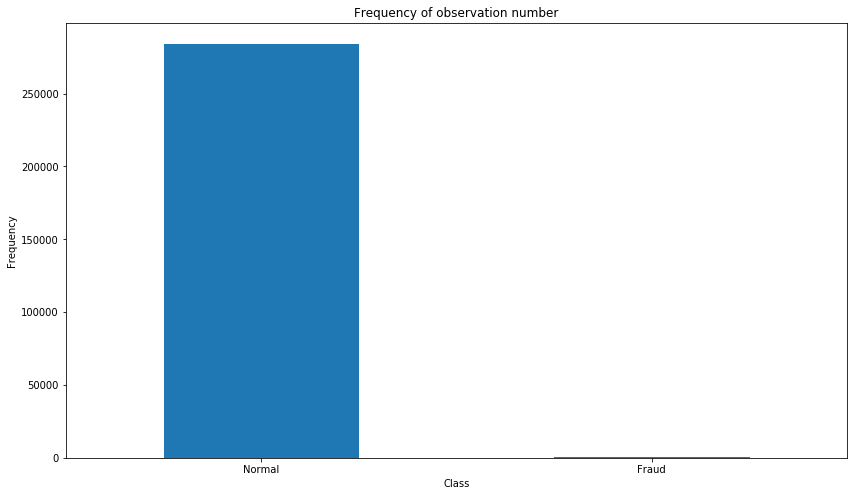

In [42]:
count_classes = pd.value_counts(df['Class'], sort= True)
count_classes.plot(kind = 'bar', rot =0)
plt.xticks(range(2), LABELS)
plt.xlabel('Class') 
plt.ylabel('Frequency')
plt.title('Frequency of observation number')

In [43]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [44]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

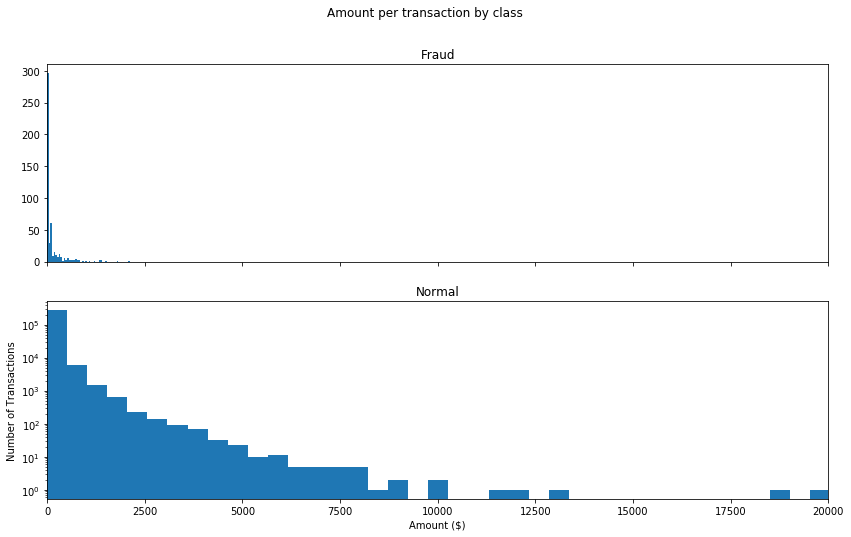

In [45]:
f, (ax1, ax2) = plt.subplots(2,1,sharex = True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim(0, 20000)
plt.yscale('log')
plt.show()

In [46]:
normal.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


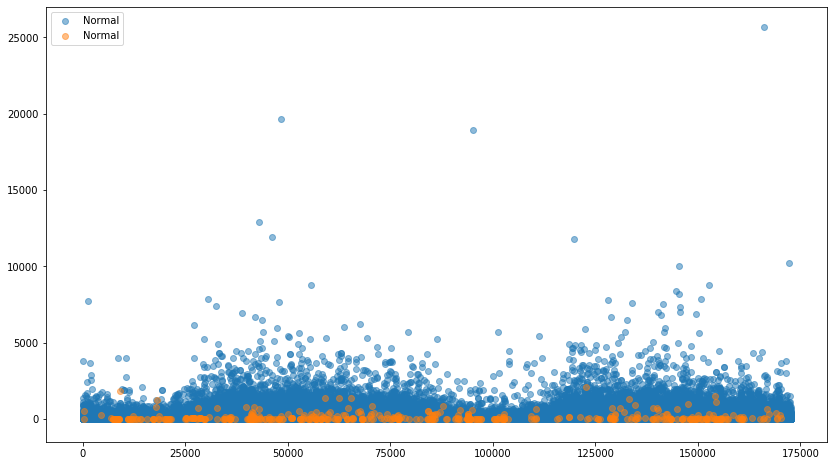

In [47]:
plt.scatter(normal.Time, normal.Amount, label = 'Normal', alpha = 0.5)
plt.scatter(fraud.Time, fraud.Amount, label = 'Normal', alpha = 0.5)

plt.legend()

In [48]:
type(df_scaled)

pandas.core.frame.DataFrame

In [51]:
df_scaled = df
df_scaled['Time'] = StandardScaler().fit_transform(df_scaled['Time'].values.reshape(-1,1))
df_scaled['Amount'] = StandardScaler().fit_transform(df_scaled['Amount'].values.reshape(-1,1))
df_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [58]:
train_x, test_x = train_test_split(df_scaled, test_size = 0.2, random_state =42)

train_x = train_x[train_x['Class'] == 0] # taking only normal transactions
train_x = train_x.drop(['Class'], axis =1) # remove class

test_y = test_x['Class'] # copy class to test_y
test_x = test_x.drop(['Class'], axis = 1) # remove class

# transfer to ndarray
train_x = train_x.values
test_y  = test_y.values


In [62]:
print(train_x.shape, test_x.shape, test_y.shape )

(227451, 30) (56962, 30) (56962,)


In [112]:
# Autoencocer

no_epochs = 50 #100
batch_size = 128
input_dim = train_x.shape[1]

encoding_dim = 100
hidden_dim = encoding_dim / 2 # keeping hidden half
learning_rate = 1e-7


#model starts here
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation = 'tanh', activity_regularizer = regularizers.l1(learning_rate)) (input_layer)
encoder = Dense(hidden_dim, activation = 'relu')(encoder)
decoder = Dense(hidden_dim, activation = 'tanh')(encoder)
decoder = Dense(input_dim, activation = 'relu')(decoder)

autoencoder = Model(inputs = input_layer, outputs = decoder)


In [113]:
# compile and run the model
autoencoder.compile(metrics = ['accuracy'],
                   loss = 'mean_squared_error',
                   optimizer = 'adam')

cp = ModelCheckpoint(filepath = 'autoencoder_fraud.h5',
                    save_best_only = True, verbose = 0)


tb = TensorBoard(log_dir = './logs',
                histogram_freq =0,
                write_graph = True,
                write_images = True)

hist = autoencoder.fit(train_x, train_x,
                      epochs =no_epochs,
                      batch_size = batch_size,
                      shuffle = True,
                      validation_data = (test_x, test_x),
                      callbacks = [cp, tb],
                      verbose = 0)



In [142]:
print('The accuracy is {0:.2f}% '.format(100*hist.history['accuracy'][-1]))

The accuracy is 95.66% 


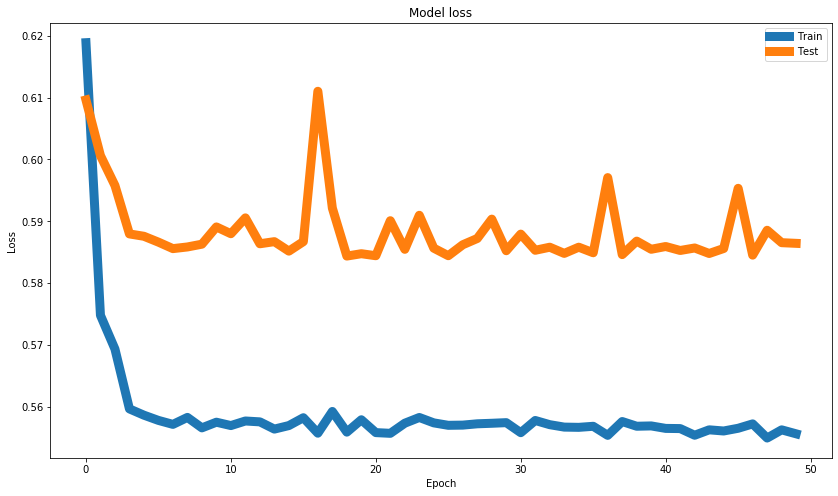

In [115]:
# Plotting model loss
plt.plot(hist.history['loss'], linewidth =9, label = 'Train')
plt.plot(hist.history['val_loss'], linewidth =9, label = 'Test')

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [116]:
#making predictions

test_x_pred = autoencoder.predict(test_x)
mse_pred = np.mean(np.power(test_x - test_x_pred, 2), axis =1)

df_error = pd.DataFrame({'Error': mse_pred, 'True_class': test_y})

df_error.describe()

,Error,True_class
count,56962.000000,56962.000000
mean,0.586434,0.001720
std,3.016591,0.041443
min,0.025047,0.000000
25%,0.176449,0.000000
50%,0.292480,0.000000
75%,0.482813,0.000000
max,249.033568,1.000000


In [117]:
df_error.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56962 entries, 43428 to 59490
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Error       56962 non-null  float64
 1   True_class  56962 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


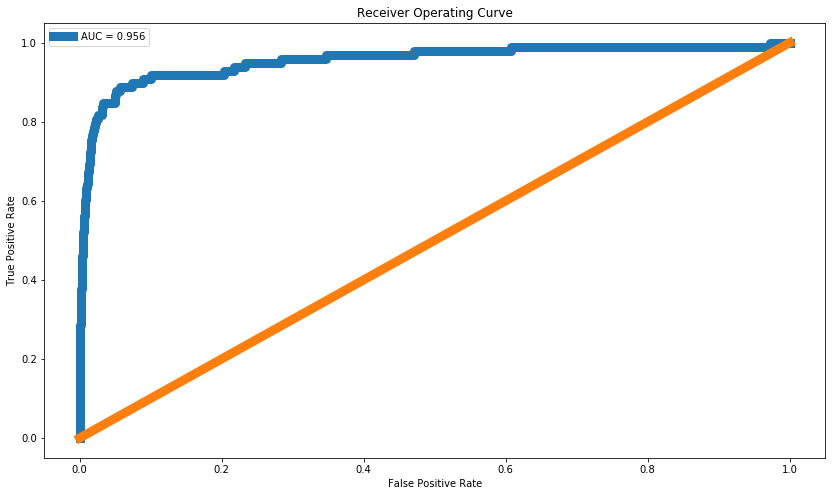

In [118]:
# plotting roc curve

false_pos_rate , true_pos_rate, thresholds = roc_curve(df_error['True_class'], df_error['Error'])
roc_auc = auc(false_pos_rate, true_pos_rate)

plt.plot(false_pos_rate, true_pos_rate, linewidth = 9, label = 'AUC = %0.3f'% roc_auc)
plt.plot([0,1], [0,1],linewidth = 9)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')

plt.legend()

In [119]:
df_error.head(3)

,Error,True_class
43428,72.268853,1
49906,0.708201,0
29474,0.206446,0


In [126]:
# confusion matrix

threshold_val = 5
def get_bool(series):
    pred_bool = []
    for i in range(len(series)):
        if series[i] > threshold_val:
            pred_bool.append(1)
        else:
            pred_bool.append(0)
            
    return pred_bool
pred_y = get_bool(df_error['Error'].values)

In [127]:
pred_y[0:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

True Positve 56328
False Positve 36
False Negative 536
True Negative 62


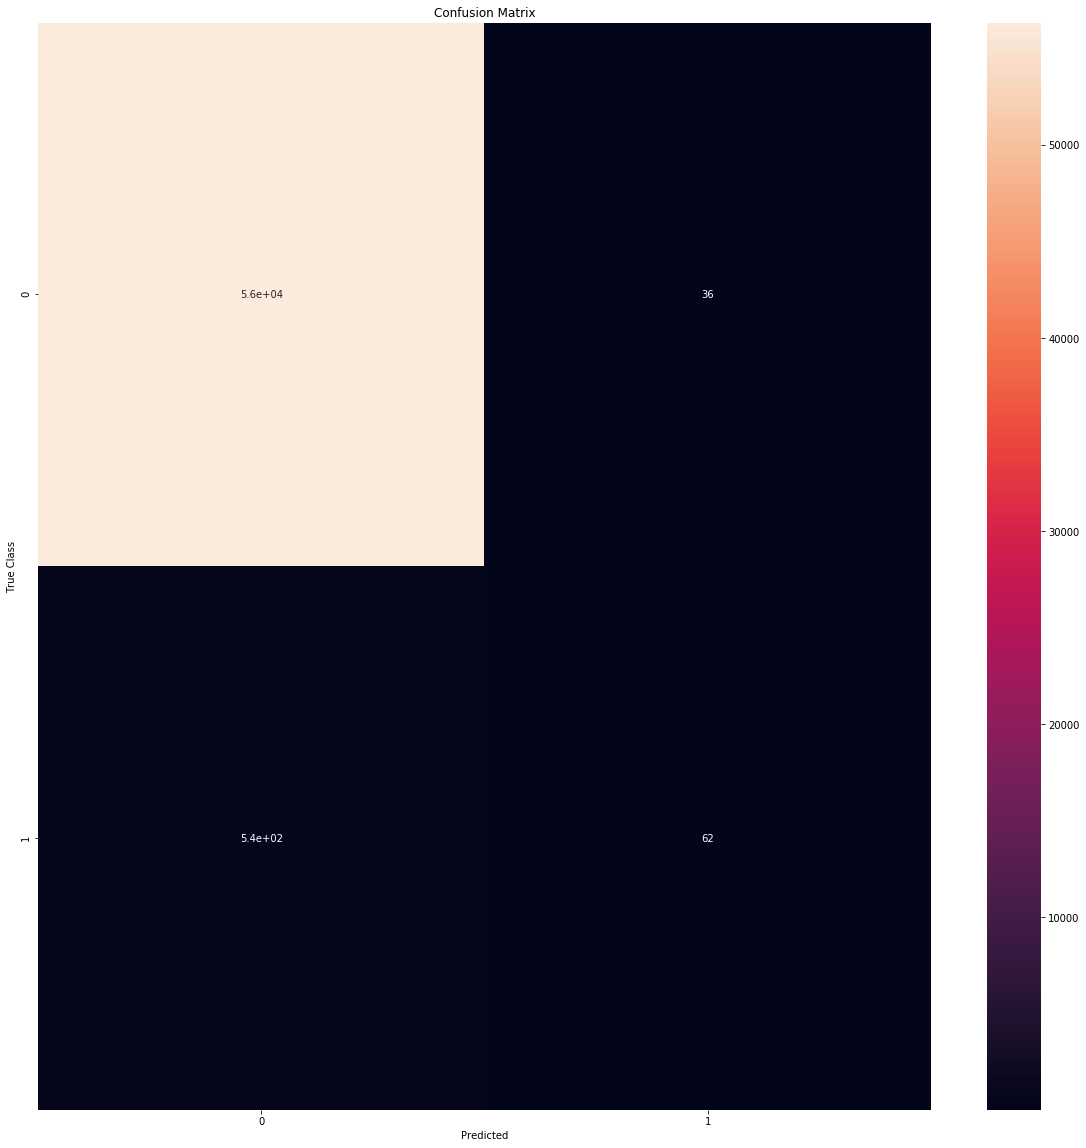

In [128]:
conf_mat = confusion_matrix(pred_y, df_error['True_class'])
print('True Positve', conf_mat[0][0])
print('False Positve', conf_mat[0][1])
print('False Negative', conf_mat[1][0])
print('True Negative', conf_mat[1][1])

plt.figure(figsize = (20,20))
sns.heatmap(conf_mat, annot = True )
plt.xlabel('Predicted')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()